In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nixtla

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


In [3]:
from nixtla import NixtlaClient

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
nixtla_client = NixtlaClient(
    api_key = 'nixtla-tok-nCwFif4t8tbU95v2Pi3eCZj1R2VFgS5nMdBy99thVKSvVAuZzv13kZwWXiDlmp7W3yiRLBmn8rwMndjW'
)
nixtla_client.validate_api_key()

True

# Nixtla Example

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
df.tail()

,timestamp,value
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


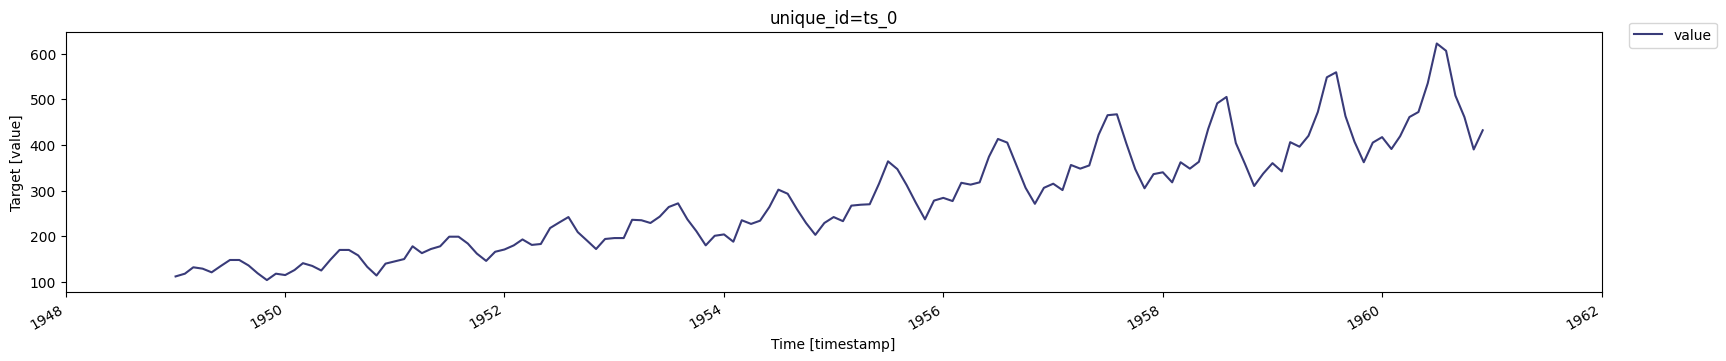

In [9]:
nixtla_client.plot(df, time_col='timestamp', target_col='value')

In [10]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=12, freq='MS', time_col='timestamp', target_col='value')
timegpt_fcst_df.head()

,timestamp,TimeGPT
0,1961-01-01,437.83792
1,1961-02-01,426.06270
2,1961-03-01,463.11655
3,1961-04-01,478.24450
4,1961-05-01,505.64648


In [ ]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=6, time_col='timestamp', target_col='value', freq='MS')
nixtla_client.plot(df, timegpt_fcst_df, time_col='timestamp', target_col='value')

# Data

In [6]:
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=806788615545323fd627a74475aca1550781d643b213ebfd9e771b999f89d73b
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [7]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import tqdm
import yfinance as yf
from torch.utils.data import DataLoader
from torch.distributions import Categorical
import tqdm
from google.colab import runtime
# Finance Data
import pandas as pd
import pandas_ta as ta
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from torch.utils.data import DataLoader


seaborn.set_context(context="talk")
%matplotlib inline

In [8]:
def extract_data(start_year, end_year=2023, ticker="^SPX"):
    data = yf.Ticker(ticker).history(period="max")
    data = data.dropna()

    def add_features(data):
      # Assuming your DataFrame is named 'data'
      data.ta.sma(close="Close", length=50, append=True)
      data.ta.sma(close="Close", length=200, append=True)
      #data.ta.ichimoku(close="Close", append=True)
      #data.ta.macd(close="Close", append=True)
      data.ta.rsi(close="Close", append=True)
      data.ta.bbands(close="Close", append=True)
      data.ta.macd(close="Close", append=True)
      data.ta.ichimoku(close="Close", append=True)
      data.ta.smi(close="Close", append=True)
      data.ta.willr(close="Close", low="Low", high="High", append=True)
      data.ta.stoch(close="Close", low="Low", high="High", append=True)
      data.ta.fisher(low="Low", high="High", append=True)
      data.ta.atr(low="Low", high="High", close="Close", append=True)
      #data.ta.cdl_pattern(name=['eveningstar', '3whitesoldiers', 'morningstar', '3blackcrows', '3linestrike'])
      data.ta.obv(volume="Volume", close="Close", append=True)
      data.ta.zscore(close="Close", append=True)
      data.ta.entropy(close="Close", append=True)
      return data

    data = add_features(data)
    ## Columns to Drop
    drop = ['Volume', 'Dividends', 'Stock Splits']
    data = data.drop(drop, axis=1)
    data = data.dropna()
    start_year = data.index[0].year if start_year is None else start_year
    data = data[data.index.year >= start_year-1] if start_year is not None else data
    data = data[data.index.year <= end_year] if end_year is not None else data
    #print(f"start year: {start_year}")
    #print(data)
    return data

df = extract_data(1990)
#df = df['Close']
df

,Open,High,Low,Close,SMA_50,SMA_200,RSI_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,...,SMIo_5_20_5,WILLR_14,STOCHk_14_3_3,STOCHd_14_3_3,FISHERT_9_1,FISHERTs_9_1,ATRr_14,OBV,ZS_30,ENTP_10
Date,,,,,,,,,,,,,,,,,,,,,
1989-01-03 00:00:00-05:00,277.720001,277.720001,273.809998,275.309998,274.762200,268.111900,48.838065,274.613084,277.267993,279.922903,...,-0.057734,-77.409688,54.631409,58.669202,0.388937,0.797978,2.233492,2.680319e+10,0.229301,3.325722
1989-01-04 00:00:00-05:00,275.309998,279.750000,275.309998,279.429993,274.677599,268.165350,58.288271,274.697225,277.787994,280.878764,...,-0.011009,-15.361706,54.945716,57.522858,0.248036,0.388937,2.391100,2.695289e+10,1.197195,3.325502
1989-01-05 00:00:00-05:00,279.429993,281.510010,279.429993,280.010010,274.632200,268.221200,59.424554,274.949366,278.373999,281.798632,...,0.014795,-19.480489,62.582706,57.386610,0.507648,0.248036,2.368880,2.712693e+10,1.312146,3.326466
1989-01-06 00:00:00-05:00,280.010010,282.059998,280.010010,280.670013,274.598000,268.280000,60.735306,274.775049,278.628003,282.480957,...,0.030888,-16.848292,82.769838,66.766086,0.908969,0.507648,2.346102,2.728826e+10,1.453896,3.327660
1989-01-09 00:00:00-05:00,280.670013,281.890015,280.320007,280.980011,274.590000,268.368150,61.366579,275.167730,279.280005,283.392280,...,0.037330,-13.090746,83.526824,76.293122,1.352505,0.908969,2.290666,2.745144e+10,1.477710,3.329150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,4468.218584,4335.861046,71.069402,4694.534676,4741.732031,4788.929386,...,-0.054860,-10.098875,80.663261,83.908053,2.832599,2.986470,41.184150,1.379242e+12,1.638294,3.350524
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,4477.157988,4340.426846,72.704374,4694.610700,4748.570020,4802.529339,...,-0.035086,-4.185293,90.737754,85.128169,2.967104,2.832599,40.391734,1.381756e+12,1.736890,3.350531
2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,4485.316992,4345.055946,73.256889,4692.545294,4751.212012,4809.878729,...,-0.019366,-1.730508,94.661774,88.687597,3.241961,2.967104,38.684484,1.384504e+12,1.720615,3.349759


In [17]:
train_df = extract_data(1991, end_year=2020)
target = 'Close'
train_df['Date'] = train_df.index
cols = list(train_df.columns)
cols.remove(target)
cols.remove('Date')
train_df = train_df[['Date'] + cols + [target]]
train_df
#cols.remove('year')

,Date,Open,High,Low,SMA_50,SMA_200,RSI_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,...,WILLR_14,STOCHk_14_3_3,STOCHd_14_3_3,FISHERT_9_1,FISHERTs_9_1,ATRr_14,OBV,ZS_30,ENTP_10,Close
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,344.046799,331.858400,70.405455,342.936187,351.876001,360.815815,...,0.000000,90.486053,77.301677,1.078280,0.549998,3.390254,3.547611e+10,2.745760,3.323556,359.690002
1990-01-03 00:00:00-05:00,1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,344.278799,332.202600,68.207999,345.637447,354.266003,362.894559,...,-8.730856,95.477155,88.087703,1.574706,1.078280,3.340949,3.528378e+10,2.249032,3.331445,358.760010
1990-01-04 00:00:00-05:00,1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,344.495599,332.524300,61.355763,348.953322,355.638007,362.322691,...,-23.473210,89.265311,91.742840,1.660051,1.574706,3.521595,3.510678e+10,1.522184,3.337278,355.670013
1990-01-05 00:00:00-05:00,1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,344.665599,332.832850,54.708974,350.111208,355.944006,361.776805,...,-40.028567,75.922456,86.888307,1.395517,1.660051,3.578625,3.494825e+10,0.747371,3.340249,352.200012
1990-01-08 00:00:00-05:00,1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,344.891400,333.156900,57.007254,350.318382,356.022009,361.725637,...,-32.442703,68.018507,77.735425,1.004608,1.395517,3.587293,3.508836e+10,1.035944,3.342378,353.790009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 00:00:00-05:00,2020-12-24 00:00:00-05:00,3694.030029,3703.820068,3689.320068,3563.210796,3209.924750,61.278661,3680.469633,3696.931982,3713.394332,...,-25.337492,64.355226,64.726743,0.581916,0.665773,38.403235,1.350134e+12,1.027925,3.326117,3703.060059
2020-12-28 00:00:00-05:00,2020-12-28 00:00:00-05:00,3723.030029,3740.510010,3723.030029,3568.251196,3215.046450,65.834224,3667.192370,3702.122021,3737.051673,...,-4.808045,76.843262,67.548495,0.831614,0.581916,38.335143,1.353669e+12,1.605991,3.328404,3735.360107
2020-12-29 00:00:00-05:00,2020-12-29 00:00:00-05:00,3750.010010,3756.120117,3723.310059,3573.115796,3221.751001,63.753548,3669.684262,3708.546045,3747.407828,...,-23.696241,82.052740,74.417076,1.209746,0.831614,37.940494,1.350276e+12,1.347583,3.330818,3727.040039


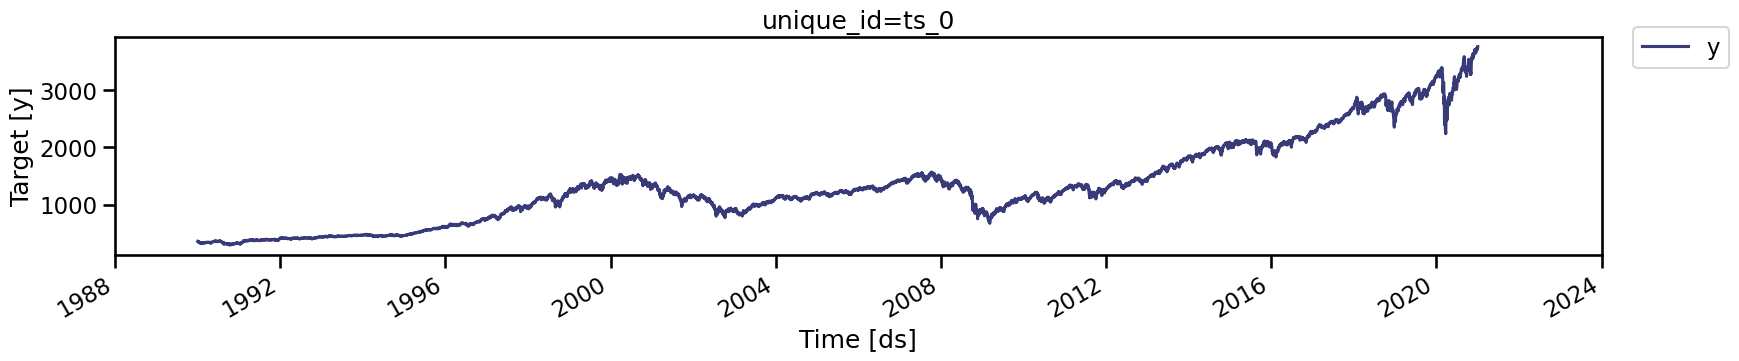

In [11]:
plot_df = train_df
plot_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
nixtla_client.plot(plot_df)

In [23]:
timegpt_finetune_mse_df = nixtla_client.forecast(
    df=df,
    h=1,
    freq='B',
    date_features=True,
    finetune_steps=100,
    finetune_loss='mse',   # Set your desired loss function
    time_col='Date',
    target_col='Close',
)

In [36]:
a = timegpt_finetune_mse_df['TimeGPT'].iloc[0]
a

4719.428

In [ ]:
timegpt_finetune_mse_df.forecast(
    df=df,
    h=1,
    freq='B',
    date_features=True,
    finetune_steps=100,
    finetune_loss='mse',   # Set your desired loss function
    time_col='Date',
    target_col='Close',
)

In [24]:
test_df = extract_data(2022, end_year=2023)
target = 'Close'
test_df['Date'] = test_df.index
cols = list(test_df.columns)
cols.remove(target)
cols.remove('Date')
test_df = test_df[['Date'] + cols + [target]]
test_df

,Date,Open,High,Low,SMA_50,SMA_200,RSI_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,...,WILLR_14,STOCHk_14_3_3,STOCHd_14_3_3,FISHERT_9_1,FISHERTs_9_1,ATRr_14,OBV,ZS_30,ENTP_10,Close
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,2021-01-04 00:00:00-05:00,3764.610107,3769.989990,3662.709961,3590.778994,3241.011401,54.983065,3694.651572,3730.232031,3765.812491,...,-51.936247,75.061605,81.164824,1.761295,1.988448,41.333487,1.351595e+12,0.547113,3.329548,3700.649902
2021-01-05 00:00:00-05:00,2021-01-05 00:00:00-05:00,3698.020020,3737.830078,3695.070068,3596.246396,3248.121102,58.940945,3693.283382,3728.532031,3763.780680,...,-32.304606,70.834048,76.790198,1.358967,1.761295,41.435381,1.356186e+12,1.051188,3.329010,3726.860107
2021-01-06 00:00:00-05:00,2021-01-06 00:00:00-05:00,3712.199951,3783.040039,3705.340088,3601.901396,3255.674802,61.871927,3694.319875,3732.752002,3771.184129,...,-23.812863,63.982095,69.959249,1.417723,1.358967,44.025707,1.362250e+12,1.538795,3.330026,3748.139893
2021-01-07 00:00:00-05:00,2021-01-07 00:00:00-05:00,3764.709961,3811.550049,3764.709961,3609.957798,3262.457102,68.254185,3678.618025,3747.102002,3815.585979,...,-4.432517,79.816671,71.544271,1.683680,1.417723,45.410311,1.367349e+12,2.713094,3.333544,3803.790039
2021-01-08 00:00:00-05:00,2021-01-08 00:00:00-05:00,3815.050049,3826.689941,3783.600098,3618.637798,3269.202701,70.266214,3667.618760,3760.823975,3854.029190,...,-1.056732,90.232629,78.010465,2.039846,1.683680,45.244563,1.372122e+12,2.731724,3.337363,3824.679932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4468.218584,4335.861046,71.069402,4694.534676,4741.732031,4788.929386,...,-10.098875,80.663261,83.908053,2.832599,2.986470,41.184150,1.379242e+12,1.638294,3.350524,4754.629883
2023-12-26 00:00:00-05:00,2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4477.157988,4340.426846,72.704374,4694.610700,4748.570020,4802.529339,...,-4.185293,90.737754,85.128169,2.967104,2.832599,40.391734,1.381756e+12,1.736890,3.350531,4774.750000
2023-12-27 00:00:00-05:00,2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4485.316992,4345.055946,73.256889,4692.545294,4751.212012,4809.878729,...,-1.730508,94.661774,88.687597,3.241961,2.967104,38.684484,1.384504e+12,1.720615,3.349759,4781.580078


In [29]:
test_df.iloc[3]['Close']

3803.7900390625

In [37]:
for i in range(5):
  print(i)

0
1
2
3
4


In [38]:
seq_len = 30
hit_count = 0
only_long = 0
total_count = len(test_df) - seq_len - 1
for i in range(len(test_df) - seq_len - 1):
  seq = test_df.iloc[i:i+seq_len]
  last_price = test_df.iloc[i+seq_len]['Close']
  preds = nixtla_client.forecast(df=seq, h=1, freq='B', time_col='Date', target_col='Close', date_features=True)
  pred_value = preds['TimeGPT'].iloc[0]
  true_price = test_df.iloc[i+seq_len+1]['Close']
  if (pred_value > last_price and true_price > last_price) or (pred_value <= last_price and true_price <= last_price):
    hit_count += 1
  if pred_value > last_price:
    only_long += 1

In [39]:
print(f"Hit Ratio: {hit_count/total_count} | Only Long: {only_long/total_count} | Total Count: {total_count}")

Hit Ratio: 0.4889196675900277 | Only Long: 0.5235457063711911 | Total Count: 722


In [39]:
timegpt_fcst_df = nixtla_client.forecast(df=df, h=1, freq='B',
                                         time_col='Date', target_col='Close',
                                         date_features=True, )
timegpt_fcst_df.tail()

,Date,TimeGPT
360,1992-05-19 00:00:00-04:00,285.22836
361,1992-05-20 00:00:00-04:00,282.67200
362,1992-05-21 00:00:00-04:00,283.10074
363,1992-05-22 00:00:00-04:00,284.59894
364,1992-05-25 00:00:00-04:00,283.61108


In [45]:
df = extract_data(1990, end_year=1990)
target = 'Close'
df['Date'] = df.index
cols = list(df.columns)
cols.remove(target)
cols.remove('Date')
df = df[['Date'] + cols + [target]]
timegpt_fcst_finetune_mae_df = nixtla_client.forecast(
    df=df,
    h=1,
    freq='B',
    date_features=True,
    finetune_steps=1,
    finetune_loss='mae',   # Set your desired loss function
    time_col='Date',
    target_col='Close',
)

In [17]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class StockDataset(Dataset):
    def __init__(self, tickers, flag='train', size=None, one_hot_datetime=False,
                 features='S', target='Close', scale=True, timeenc=0, freq='d', batch_size=5,
                 data_start_year=1990, data_end_year=2023):
        if size is None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]

        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        self.data_start_year = data_start_year
        self.data_end_year = data_end_year

        self.features = features
        self.target = target
        self.scale = scale
        self.one_hot_datetime = one_hot_datetime
        self.timeenc = timeenc
        self.freq = freq
        self.scaler = StandardScaler()
        self.tickers = tickers.split()
        self.ticker_database = {}
        self.batch_size = batch_size
        self.min_year = 0
        self.__read_data__()

    def __len__(self):
        return len(self.years) - 1

    def get_min_year(self):
        min_year = 0
        for ticker in self.tickers:
            self.ticker_database[ticker] = extract_data(start_year=None, ticker=ticker)
            min_year = max(min_year, self.ticker_database[ticker].index.year.min())
        return min_year + 2

    def __read_data__(self):
        print(f"Loading following tickers: {self.tickers}\n")

        self.min_year = max(self.get_min_year(), self.data_start_year)
        print(f"Dataset Start Year: {self.min_year} | End Year: {self.data_end_year}")
        for ticker in self.tickers:
            self.ticker_database[ticker] = extract_data(start_year=self.min_year, end_year=self.data_end_year, ticker=ticker)
            self.ticker_database[ticker]['year'] = self.ticker_database[ticker].index.year

        self.years = self.ticker_database[self.tickers[0]]['year'].unique()
        print(f"years: {self.years}")
        self.data_by_year = {year: {ticker: self.ticker_database[ticker][self.ticker_database[ticker]['year'] == year] for ticker in self.tickers} for year in self.years}

        self.data_len = len(self.years)
        print(f"Data Normalization: {self.scale}")
        print(f"DateTime is one-hot: {self.one_hot_datetime}")

    def __getitem__(self, idx):
        """
        Final item form is a list containing [seq_x, seq_y, seq_x_mark, seq_y_mark, seq_x_dates, seq_y_dates]
        batches_x = batches[0]
        batches_y = batches[1]
        batches_x_mark = batches[2]
        batches_y_mark = batches[3]
        batches_x_dates = batches[4]
        batches_y_dates = batches[5]

        Each batches, contain batch data of size (batch_size, seq_len, num_features)
        For example, if seq_len = 24, batch_size = 5, num_features = 32,
        Each item of batches_x is a tensor of (5, 24, 32)
        """
        year = self.min_year + idx if idx >= 0 else self.max_year + idx + 1
        #print(f"Stock Dataset Yeaer: {year}")
        raw_datas = []

        for ticker in self.tickers:
            if year - 1 in self.data_by_year:
                prev_year_data = self.data_by_year[year - 1][ticker].tail(self.seq_len + self.pred_len - 1)
                #print(f"Prev year data for {ticker} in {year}: {prev_year_data.index}")
            else:
                print(f"Previous Year Data is Insufficient, Year: {year-1}, Ticker: {ticker}")
                prev_year_data = pd.DataFrame()

            ticker_data = pd.concat([prev_year_data, self.data_by_year[year][ticker]])
            #print(f"Ticker data for {ticker} in {year}: {ticker_data.index}")
            ticker_data['date'] = ticker_data.index
            raw_datas.append(ticker_data)
            """print(f"Ticker: {ticker}")
            print(len(ticker_data))
            print(ticker_data)"""

        seq_x = []
        seq_y = []
        seq_x_mark = []
        seq_y_mark = []
        seq_x_dates = []
        seq_y_dates = []

        for item in raw_datas:
            x, y, x_mark, y_mark, x_dates, y_dates = self.make_data(item)
            seq_x.append(x)
            seq_y.append(y)
            seq_x_mark.append(x_mark)
            seq_y_mark.append(y_mark)
            seq_x_dates.append(x_dates)
            seq_y_dates.append(y_dates)

        # Combine all tickers into a single batch and slice them into mini-batches
        #print(len(seq_x))
        return self.create_batches(seq_x, seq_y, seq_x_mark, seq_y_mark, seq_x_dates, seq_y_dates), year

    def make_data(self, raw_data):
        target = 'Close'
        cols = list(raw_data.columns)
        cols.remove(self.target)
        cols.remove('Date')
        cols.remove('year')
        raw_data = raw_data[['date'] + cols + [self.target]]

        if self.features == 'MS':
            cols_data = raw_data.columns[1:]
            data = raw_data[cols_data]
        elif self.features == 'S':
            data = raw_data['Close']

        if self.scale:
            data = self.scaler.fit_transform(data.values)

        if self.one_hot_datetime:
          #print(type(pd.to_datetime(raw_data['date'].values)))
          data_stamp = datetime_to_one_hot(pd.to_datetime(raw_data['date'].values))
          #print(one_hot_data_stamp.shape)
        else:
          data_stamp = raw_data['date'].values

        """else:
          data_stamp = time_features(pd.to_datetime(raw_data['date'].values), freq=self.freq)
          data_stamp = data_stamp.transpose(1, 0)"""

        """print("----Yearly data----")
        print(data[0].shape)
        print(len(data))
        print(data)"""

        seq_x = []
        seq_y = []
        seq_x_mark = []
        seq_y_mark = []
        x_dates = []
        y_dates = []

        for i in range(len(data) - self.pred_len - self.seq_len + 1):
            s_begin = i
            s_end = s_begin + self.seq_len
            r_begin = s_end - self.label_len
            r_end = r_begin + self.label_len + self.pred_len

            seq_x.append(data[s_begin:s_end])
            seq_y.append(data[r_begin:r_end])
            seq_x_mark.append(data_stamp[s_begin:s_end])
            seq_y_mark.append(data_stamp[r_begin:r_end])
            x_dates.append(raw_data['date'][s_begin:s_end])
            y_dates.append(raw_data['date'][r_begin:r_end])
            """print(f"data[s_begin:s_end]: {data[s_begin:s_end]}")
            print(f"data[r_begin:r_end]: {data[r_begin:r_end]}")
            print(f"raw_data['date'][s_begin:s_end]: {raw_data['date'][s_begin:s_end]}")
            print(f"raw_data['date'][r_begin:r_end]: {raw_data['date'][r_begin:r_end]}")
            print("=======================================")"""

        return torch.tensor(np.array(seq_x)), torch.tensor(np.array(seq_y)), torch.tensor(np.array(seq_x_mark)), torch.tensor(np.array(seq_y_mark)), x_dates, y_dates

In [18]:
dataset = StockDataset(tickers='^SPX',timeenc=1, freq='d', size=[36, 18, 1], features='MS')

Loading following tickers: ['^SPX']

Dataset Start Year: 1990 | End Year: 2023
years: [1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]
Data Normalization: True
DateTime is one-hot: False


In [19]:
batches, year = dataset[0]

TypeError: can't convert np.ndarray of type numpy.datetime64. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

# Trainer

In [ ]:
class Trainer():
  def __init__(self, configs):
    self.configs = configs

    ticker_str = configs.tickers.replace(" ", "_")
    self.run_name = f"[{ticker_str}]_valYrs:{self.configs.validation_years}_testYrs{self.configs.test_years}_reset:{self.configs.reset_model}_{configs.run_name}"
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.set_seed(configs.seed)
    self.dataset = self.make_data()
    self.model = Model(configs)
    self.model.to(self.device)
    self.loss_fn = nn.MSELoss()
    self.model_optim = torch.optim.Adam(self.model.parameters(), lr=configs.learning_rate)
    self.writer = SummaryWriter(f"/content/drive/MyDrive/code/fintransformer/runs/{self.run_name}")
    path = f"/content/drive/MyDrive/code/fintransformer/models/{self.configs.save_folder}/{self.run_name}"
    if not os.path.exists(path):
      os.mkdir(path)
      print(f"Save File Directory Made at {path}\n")
    else:
      print(f"Directory Already Exists at {path}")

  def make_data(self):
    def collate_fn(batch):
      seq_x, seq_y, seq_x_mark, seq_y_mark, year = batch[0]
      return seq_x, seq_y, seq_x_mark, seq_y_mark, year
    dataset = StockDataset(tickers=self.configs.tickers, timeenc=1, freq='d', size=[self.configs.seq_len, self.configs.label_len, self.configs.pred_len],
                           features=self.configs.features, batch_size=self.configs.batch_size, one_hot_datetime=self.configs.one_hot_datetime,
                           data_start_year=self.configs.data_start_year, data_end_year=self.configs.data_end_year)
    """prices, labels, year = next(iter(val_loader))
    feature_num = prices.shape[2]
    label_num = labels.shape[1]
    print(f"Data shape: {prices.shape} | Num Features: {feature_num}")"""
    return dataset

  def run(self):
    ### Training ###
    print(f"Training model: {self.configs.run_name}")
    print()
    range_limit = self.configs.rolling_window + self.configs.validation_years + self.configs.test_years
    loop_range = tqdm.tqdm(range(len(self.dataset)-range_limit))
    recent_save_path = ""
    val_acc_arr = []
    test_acc_arr = []
    for iteration in loop_range:
      highest_acc = 0.0
      highest_test_acc = 0.0
      if self.configs.reset_model and iteration != 0:
        self.model = Model(self.configs)
        self.model.to(self.device)
        self.model_optim = torch.optim.Adam(self.model.parameters(), lr=self.configs.learning_rate)
        print(f"Model Has Been Reset to Random Parameters")
      else:
        self.load_model(recent_save_path) if recent_save_path != "" else None
      for window_iteration in range(self.configs.window_epoch):
        train_loss, average_val_loss, average_val_accuracy, average_test_accuracy, validation_year, test_year = self.train(iteration, window_iteration, highest_acc)
        if average_val_accuracy > highest_acc:
            highest_acc = average_val_accuracy
            highest_test_acc = average_test_accuracy
            recent_save_path = self.save_model(average_val_accuracy, average_test_accuracy, window_iteration, validation_year, test_year)
      #self.writer.add_scalar("Train/Test Loss", train_loss, iteration)
      val_acc_arr.append([highest_acc, validation_year])
      test_acc_arr.append([highest_test_acc, test_year])
      print(f"***********************************************************")
      print(f"Highest Validation Accuracy in {validation_year[0]}~{validation_year[-1]}: {highest_acc*100:.2f}% | Highest Test Accuracy in {test_year}: {average_test_accuracy*100:.2f}%")
      print(f"***********************************************************")
      print("=============================New Training Set====================================")
    self.writer.flush()
    self.writer.close()
    #print(f"Highest Accuracy in Validation Set: {highest_acc*100:.2f}")
    print()
    for val, test in zip(val_acc_arr, test_acc_arr):
      print(f"Validation Accuracy in {val[1][0]}~{val[1][-1]} : {val[0]*100:.2f}% | Test Accuracy in {test[1]}: {test[0]*100:.2f}%")

    average_first_elements_val = sum(item[0] for item in val_acc_arr) / len(val_acc_arr)
    average_first_elements_test = sum(item[0] for item in test_acc_arr) / len(test_acc_arr)
    print(f"Average Validation Accuracy: {average_first_elements_val*100:.2f}% | Average Test Accuracy: {average_first_elements_test*100:.2f}%")
    return

  def train(self, iteration, window_iteration, highest_acc):
    # Train 10 years

    # Run trainnig

    # call test function for test the next year

    return loss_epoch, average_val_loss, average_val_accuracy, average_test_accuracy, validation_year, test_year